### 1. Importer les bibliothèques
Importation de toutes les bibliothèques nécessaires pour la manipulation des données, la visualisation, le prétraitement, la modélisation et l'évaluation.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time


ModuleNotFoundError: No module named 'missingno'

### 2. Charger les données
Chargement du jeu de données depuis le fichier CSV spécifié.
*Note : Assurez-vous que le chemin `\\France_Air_Quality\\DataExtract.csv` est correct par rapport à l'emplacement de votre notebook ou fournissez un chemin absolu. Utiliser des chaînes brutes `r'...'` ou des barres obliques `/` peut parfois être plus fiable sur différents systèmes d'exploitation.*

In [13]:
data_directory = r"C:\Projet_ESME\Pollution\Pollution\France_Air_Quality"

print(f"Chargement des Données depuis : {data_directory}")
df = None 

csvs = os.path.join(data_directory, "*.csv")
csv_files = glob.glob(csvs)
df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file, low_memory=False)
    df_list.append(temp_df)
        
    if df_list:
        df = pd.concat(df_list, ignore_index=True)

print(f"Chargement des Données terminé : {len(df_list)} fichiers concaténés")
print(f"Nombre de lignes : {df.shape[0]}")

Chargement des Données depuis : C:\Projet_ESME\Pollution\Pollution\France_Air_Quality
Chargement des Données terminé : 42 fichiers concaténés
Nombre de lignes : 584379
Chargement des Données terminé : 42 fichiers concaténés
Nombre de lignes : 584379


### 3. Exploration Initiale et Visualisation des Manquants
Affichage des premières lignes, des informations générales et visualisation des valeurs manquantes si les données ont été chargées.


 Exploration Initiale 
Aperçu des 5 premières lignes :


,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting),Observation Frequency
0,France,NaN,NaN,FR0045A,NaN,SPO-FR0045A_00003_100,SA,Strong acidity (air),P1Y,Annual mean / 1 calendar year,...,-1.5233,47.2450,NaN,Nantes ...,FR008C1 ...,450218.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN,NaN
1,France,NaN,NaN,FR0250A,NaN,SPO-FR0250A_00001_100,SO2,Sulphur dioxide (air),P1Y-day-max4,1 year day max 4,...,0.1306,49.4992,5.0,Le Havre ...,FR012C1 ...,195042.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN,NaN
2,France,NaN,NaN,FR0250A,NaN,SPO-FR0250A_00007_100,O3,Ozone (air),AOT40c,AOT40 vegetation protection,...,0.1306,49.4992,5.0,Le Havre ...,FR012C1 ...,195042.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN,NaN
3,France,NaN,NaN,FR0250A,NaN,SPO-FR0250A_00008_100,NO2,Nitrogen dioxide (air),P1Y-day-max,1 year day max,...,0.1306,49.4992,5.0,Le Havre ...,FR012C1 ...,195042.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN,NaN
4,France,NaN,NaN,FR0037A,NaN,SPO-FR0037A_00009_100,NOX,Nitrogen oxides (air),P1Y-day-max,1 year day max,...,-1.5783,47.2000,NaN,Nantes ...,FR008C1 ...,450218.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN,NaN



Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584379 entries, 0 to 584378
Data columns (total 27 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   Country                                                         584379 non-null  object 
 1   Air Quality Network                                             488496 non-null  object 
 2   Air Quality Network Name                                        488496 non-null  object 
 3   Air Quality Station EoI Code                                    584379 non-null  object 
 4   Air Quality Station Name                                        488496 non-null  object 
 5   Sampling Point Id                                               584379 non-null  object 
 6   Air Pollutant                                                   584379 non-null  object 
 7   Air P

None


 Visualisation des Valeurs Manquantes 

Visualisation (Matrice)...


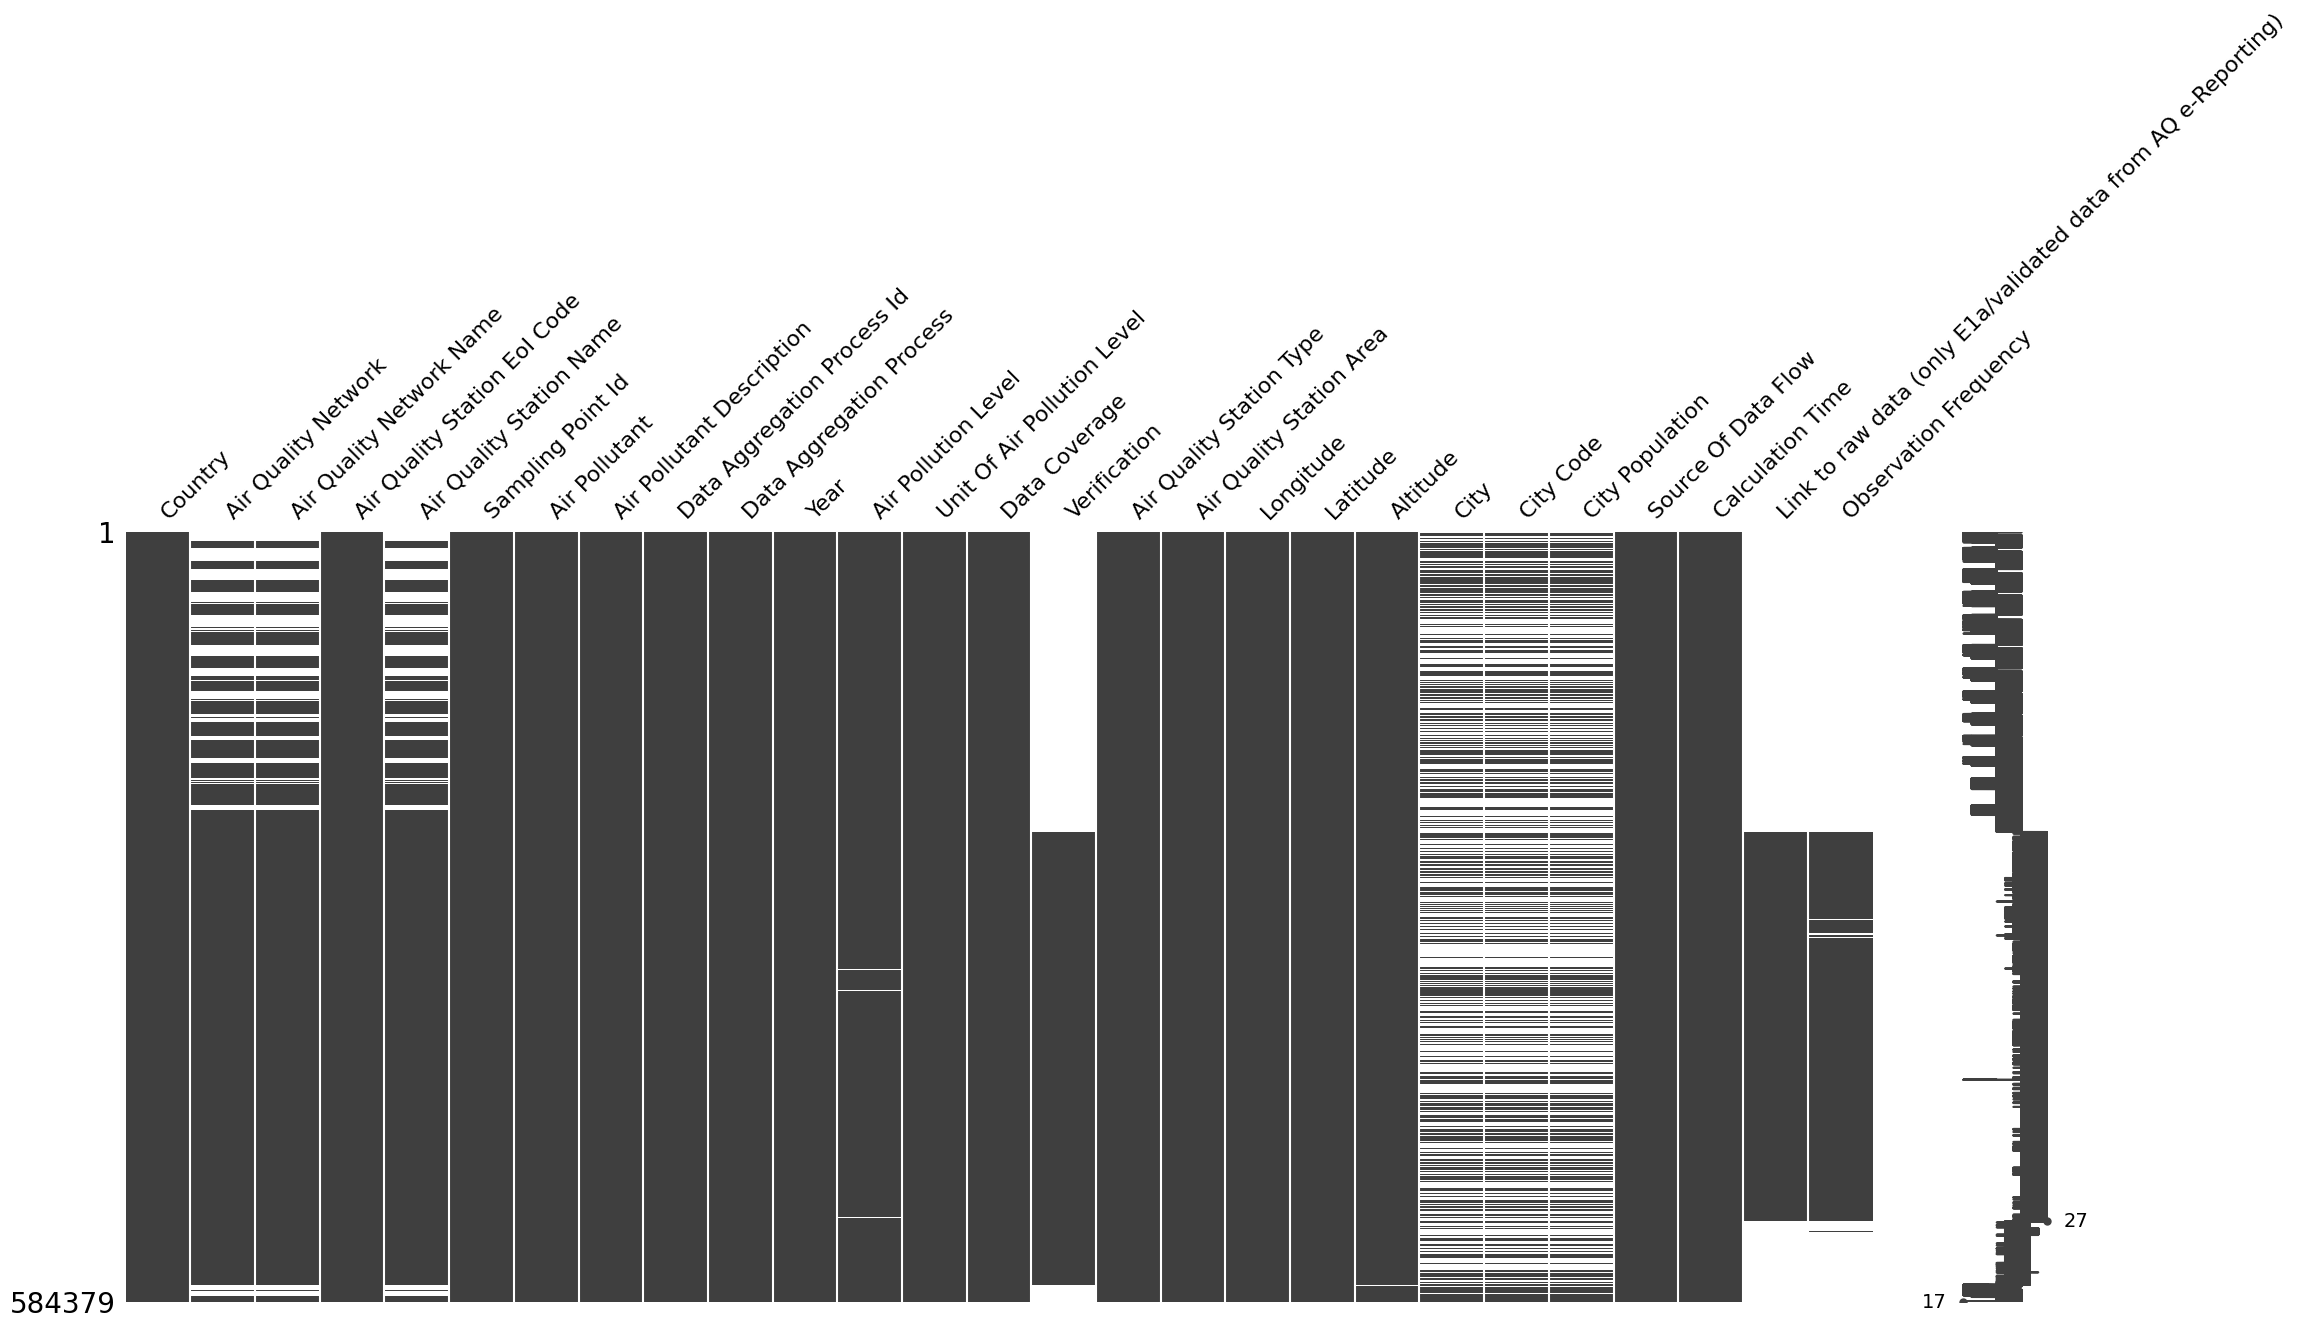


Visualisation (Heatmap)...


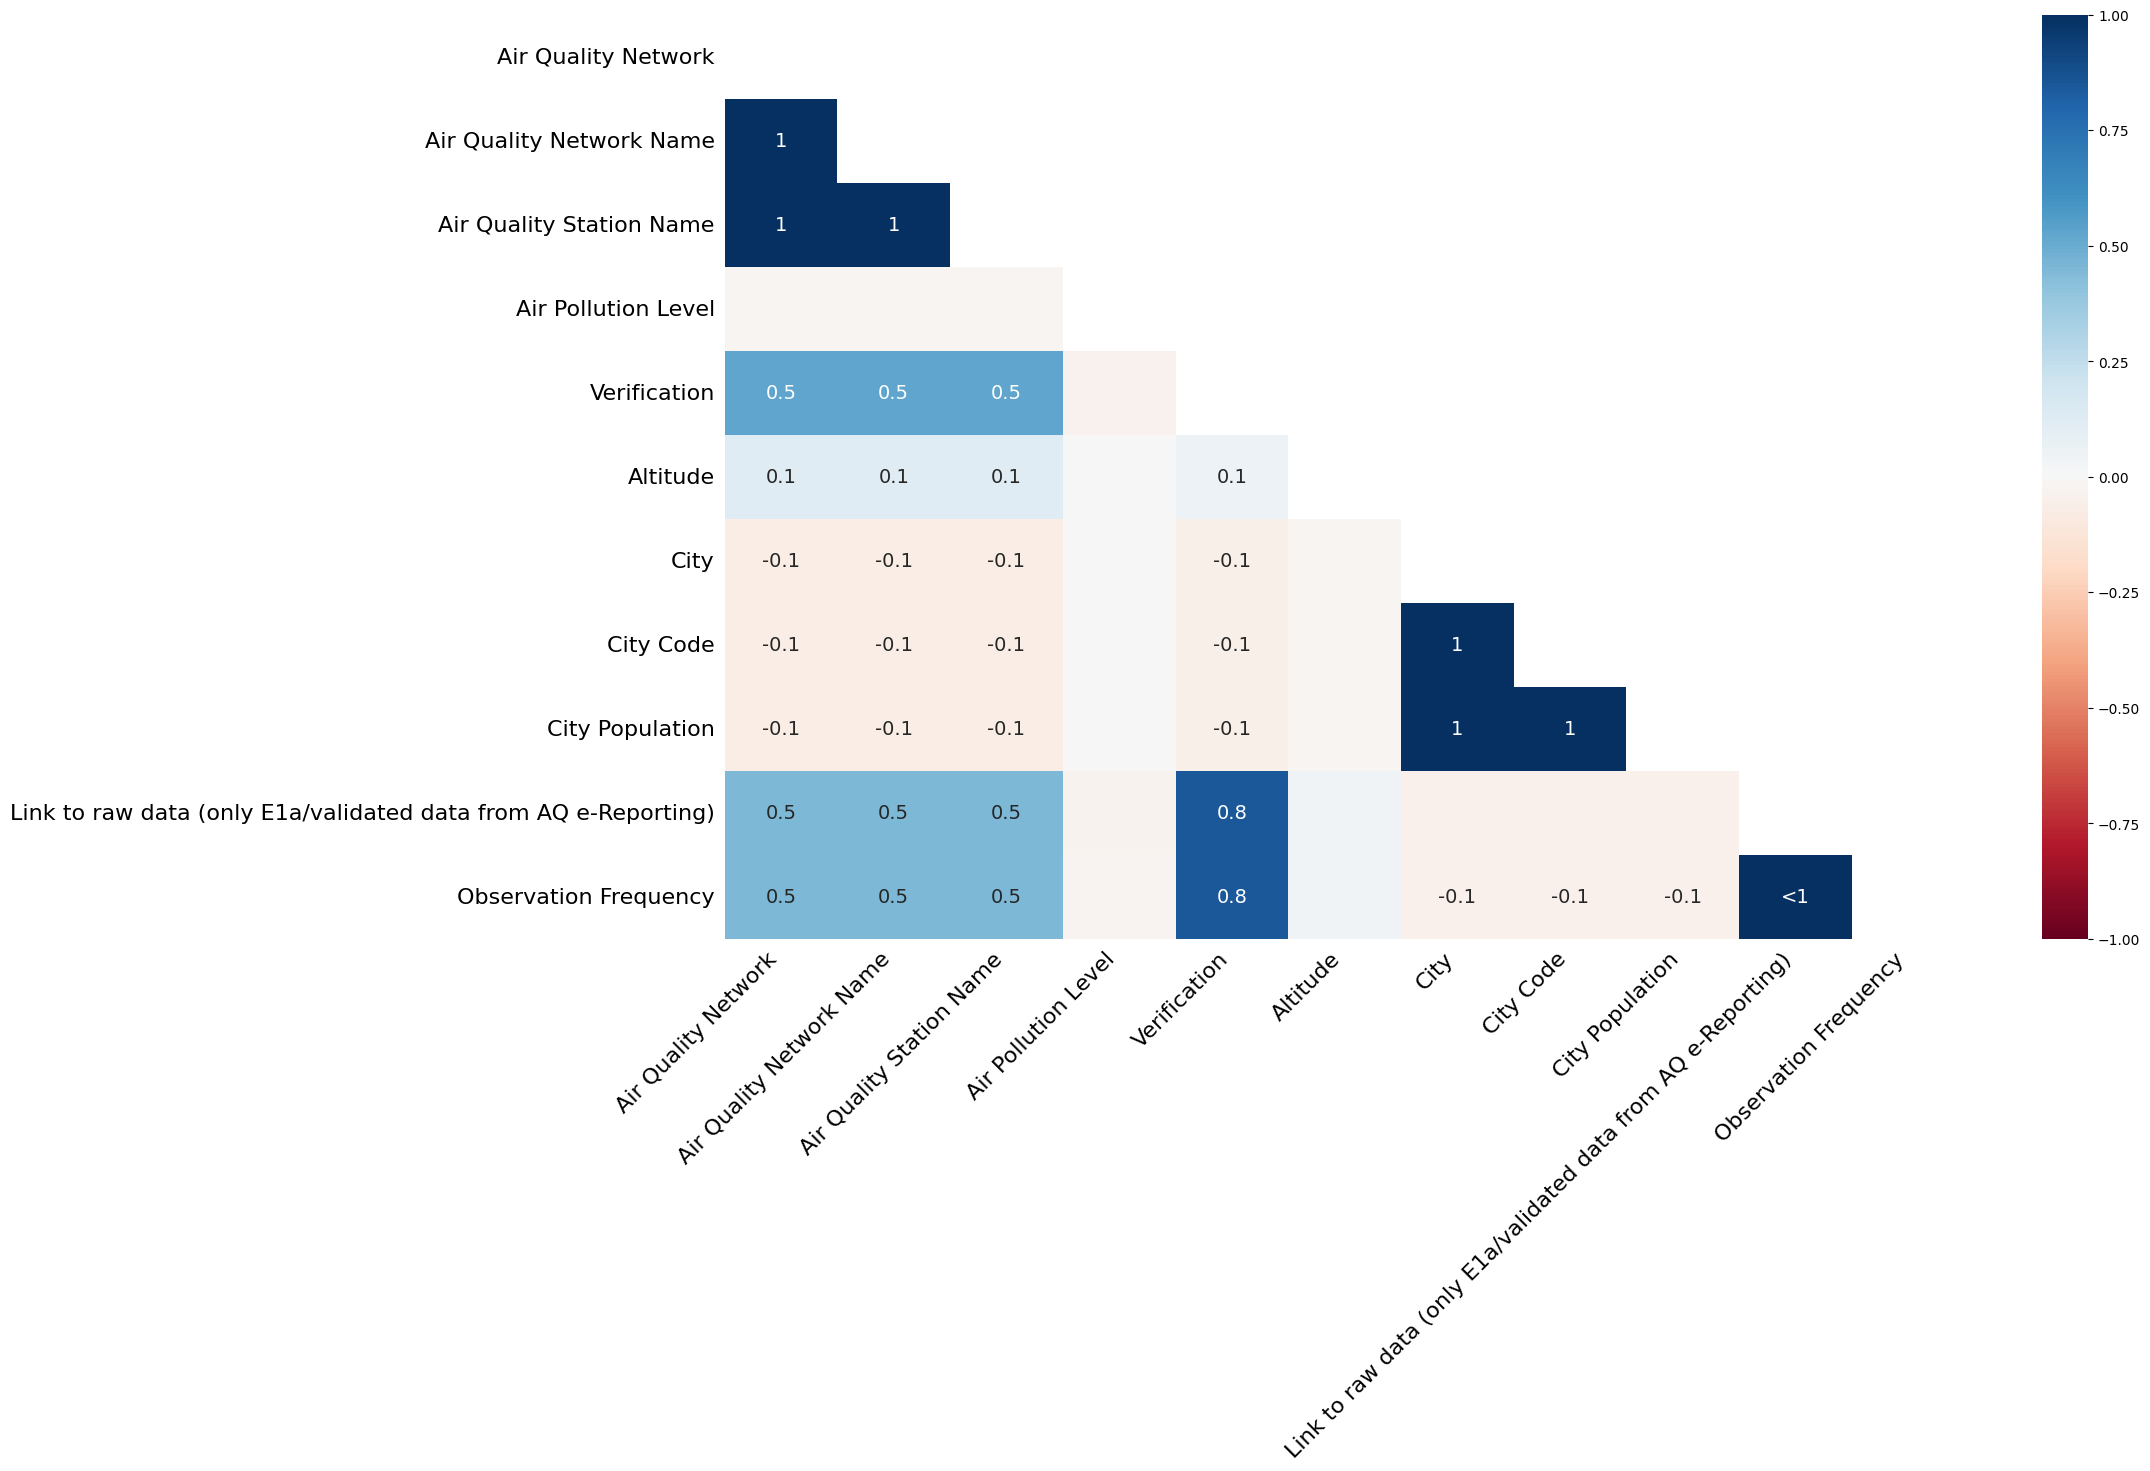

In [14]:
def exploration_initiale(df):
    if df is not None:
        print("\n Exploration Initiale ")
        print("Aperçu des 5 premières lignes :")
        display(df.head())

        print("\nInformations sur le DataFrame :")
        display(df.info())

        print("\n Visualisation des Valeurs Manquantes ")
        print("\nVisualisation (Matrice)...")
        try:
            msno.matrix(df)
            plt.show()
        except Exception as e:
            print(f"Erreur lors de la création de la matrice missingno : {e}")

        print("\nVisualisation (Heatmap)...")
        try:
            msno.heatmap(df)
            plt.show()
        except Exception as e:
            print(f"Erreur lors de la création de la heatmap missingno : {e}")
    else:
        print("DataFrame non chargé, exploration impossible.")

exploration_initiale(df)

 Gestion des données manquantes : Ville / Longitude / Lattitude / Altitude


In [ ]:
def completer_donnees_geographiques_avec_cache(df):
    geolocator = Nominatim(user_agent="votre_application_unique_ici")  
    cache_ville = {}  
    cache_coords = {}  

    for index, row in df.iterrows():
        ville_manquante = pd.isna(row['City'])
        coords_manquantes = pd.isna(row['Latitude']) or pd.isna(row['Longitude'])
        altitude_manquante = pd.isna(row['Altitude'])

        if coords_manquantes and not ville_manquante:
            if row['City'] in cache_ville:
                location = cache_ville[row['City']]
            else:
                try:
                    location = geolocator.geocode(row['City'], timeout=10)
                    cache_ville[row['City']] = location
                    time.sleep(1)  
                except (GeocoderTimedOut, GeocoderUnavailable):
                    location = None

            if location:
                df.loc[index, 'Latitude'] = location.latitude
                df.loc[index, 'Longitude'] = location.longitude
                if altitude_manquante and hasattr(location, 'altitude'):
                    df.loc[index, 'Altitude'] = location.altitude

        elif ville_manquante and not coords_manquantes:
            coords_key = (row['Latitude'], row['Longitude'])
            if coords_key in cache_coords:
                location = cache_coords[coords_key]
            else:
                try:
                    location = geolocator.reverse(coords_key, exactly_one=True, timeout=10)
                    cache_coords[coords_key] = location
                    time.sleep(1)  
                except (GeocoderTimedOut, GeocoderUnavailable):
                    location = None

            if location and location.address:
                address_components = location.raw.get('address', {})
                city = address_components.get('city', 
                                              address_components.get('town', 
                                                                     address_components.get('village',
                                                                                            address_components.get('county'))))
                if city:
                    df.loc[index, 'City'] = city
                else:
                    df.loc[index, 'City'] = location.address.split(',')[0]  # Fallback

        if altitude_manquante and not coords_manquantes:
            
            coords_key = (row['Latitude'], row['Longitude'])
            if coords_key in cache_coords:
                location = cache_coords[coords_key]
            else:
                try:
                    location = geolocator.reverse(coords_key, exactly_one=True, timeout=10)
                    cache_coords[coords_key] = location
                    time.sleep(1)  
                except (GeocoderTimedOut, GeocoderUnavailable):
                    location = None

            if location and hasattr(location, 'altitude'):
                df.loc[index, 'Altitude'] = location.altitude

    return df

df = completer_donnees_geographiques_avec_cache(df)

In [ ]:
def sauvegarder_dataframe(df, chemin_fichier):
    try:
        df.to_csv(chemin_fichier, index=False)
        print(f"DataFrame sauvegardé avec succès à l'emplacement : {chemin_fichier}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde du DataFrame : {e}")

def charger_dataframe(chemin_fichier):
    try:
        df = pd.read_csv(chemin_fichier, low_memory=False)
        print(f"DataFrame chargé avec succès depuis l'emplacement : {chemin_fichier}")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement du DataFrame : {e}")
        return None

In [ ]:
def analyze_pollutant_distribution(df, pollutant_col='Air Pollutant', print_results=True):
    if df is not None and pollutant_col in df.columns:
        pollutant_counts = df[pollutant_col].value_counts(dropna=True)
        
        pollutant_table = pollutant_counts.reset_index().head(20)
        pollutant_table.columns = [pollutant_col, 'Frequency']
        
        pollutant_table_sorted = pollutant_table.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

        top_pollutants_list = pollutant_table_sorted[pollutant_col].tolist()
        pollutant_table_sorted['Top Pollutants'] = top_pollutants_list
        pollutant_table_sorted = pollutant_table_sorted[['Top Pollutants', 'Frequency']]

        if print_results:
            print(f"Distribution des Polluants dans la colonne '{pollutant_col}'")
            try:
                display(pollutant_table_sorted)
            except NameError:
                print(pollutant_table_sorted.to_string())  
            print(f"\nNombre total de types de polluants uniques trouvés : {len(pollutant_counts)}")
            print(f"\nListe des 20 polluants les plus fréquents : {top_pollutants_list}")

        return pollutant_table_sorted, top_pollutants_list
    else:
        print(f"Erreur : Le DataFrame est vide ou la colonne '{pollutant_col}' est absente.")
        return None, None

analyze_pollutant_distribution(df)

Distribution des Polluants dans la colonne 'Air Pollutant'


,Top Pollutants,Frequency
0,O3,187777
1,NO2,130374
2,PM10,90120
3,SO2,80948
4,NO,27170
5,PM2.5,24318
6,CO,11802
7,NOX as NO2,11639
8,NOX,5248
9,C6H6,3271



Nombre total de types de polluants uniques trouvés : 102

Liste des 20 polluants les plus fréquents : ['O3', 'NO2', 'PM10', 'SO2', 'NO', 'PM2.5', 'CO', 'NOX as NO2', 'NOX', 'C6H6', 'SPM', 'BaP in PM10', 'SA', 'Pb in PM10', 'As in PM10', 'Cd in PM10', 'Ni in PM10', 'C6H5-CH3', 'C6H5-C2H5', 'o-C6H4-(CH3)2']


(   Top Pollutants  Frequency
 0              O3     187777
 1             NO2     130374
 2            PM10      90120
 3             SO2      80948
 4              NO      27170
 5           PM2.5      24318
 6              CO      11802
 7      NOX as NO2      11639
 8             NOX       5248
 9            C6H6       3271
 10            SPM        954
 11    BaP in PM10        928
 12             SA        855
 13     Pb in PM10        838
 14     As in PM10        784
 15     Cd in PM10        759
 16     Ni in PM10        758
 17       C6H5-CH3        633
 18      C6H5-C2H5        477
 19  o-C6H4-(CH3)2        461,
 ['O3',
  'NO2',
  'PM10',
  'SO2',
  'NO',
  'PM2.5',
  'CO',
  'NOX as NO2',
  'NOX',
  'C6H6',
  'SPM',
  'BaP in PM10',
  'SA',
  'Pb in PM10',
  'As in PM10',
  'Cd in PM10',
  'Ni in PM10',
  'C6H5-CH3',
  'C6H5-C2H5',
  'o-C6H4-(CH3)2'])

Pour la suite, nous allons sélectionner les polluants suivants et générer un modèle spécifique pour chacun : ['O3', 'NO2', 'PM10', 'SO2', 'NO', 'PM2.5', 'CO', 'NOX'].

### 4. Nettoyage des Données
Suppression des colonnes jugées inutiles et des lignes où la variable cible (`Air Pollution Level`) est manquante ou non numérique.

In [ ]:
print("\nNettoyage des Données")

# Suppression des lignes où "Data Coverage" est inférieur à 70
if 'Data Coverage' in df.columns:
    initial_rows = df.shape[0]
    df = df[df['Data Coverage'] >= 70]
    rows_after_filter = df.shape[0]
    print(f"Lignes supprimées (Data Coverage < 70) : {initial_rows - rows_after_filter}")
    print(f"Dimensions après filtrage : {df.shape}")
# 4.1 Suppression des Colonnes Inutiles
initial_cols = df.shape[1]
drop_cols = ['Country', 'Air Quality Network',"Data Coverage", 'Air Quality Network Name',
                'Air Quality Station EoI Code', 'Air Quality Station Name',
                'Sampling Point Id','Air Pollutant Descritpion', 'Data Aggregation Process Id',
                'Data Aggregation Process','Air Quality Station Type', 'Unit Of Air Pollution Level',
                'Verification', 'City Code', 'Source Of Data Flow',
                'Calculation Time', 'Link to raw data (only E1a/validated data from AQ e-Reporting)',
                'Observation Frequency','City Population']

cols_to_drop_existing = [col for col in drop_cols if col in df.columns]
df.drop(columns=cols_to_drop_existing, inplace=True)
print(f"Colonnes supprimées : {len(cols_to_drop_existing)}")
print(f"Dimensions après suppression colonnes : {df.shape}")

# 4.2 Traitement de la Cible et Suppression des Lignes Manquantes/Invalides
if 'Air Pollution Level' in df.columns:
    initial_rows = df.shape[0]
    df['Air Pollution Level'] = pd.to_numeric(df['Air Pollution Level'], errors='coerce')
    rows_before_nan_drop = df.shape[0]
    df.dropna(subset=['Air Pollution Level', 'Air Pollutant'], inplace=True)
    rows_after_nan_drop = df.shape[0]
    print(f"Lignes supprimées (cible ou polluant manquant/non numérique) : {initial_rows - rows_after_nan_drop}")
    print(f"Dimensions après suppression lignes : {df.shape}")




Nettoyage des Données
Lignes supprimées (Data Coverage < 70) : 76379
Dimensions après filtrage : (508000, 27)
Colonnes supprimées : 18
Dimensions après suppression colonnes : (508000, 9)
Lignes supprimées (cible ou polluant manquant/non numérique) : 0
Dimensions après suppression lignes : (508000, 9)


In [24]:
# Création de DataFrames individuels pour chaque polluant et suppression des colonnes 'Air Pollutant' et 'Air Pollutant Description'
if df is not None and 'Air Pollutant' in df.columns and 'Air Pollutant Description' in df.columns:
    for pollutant in ['O3', 'NO2', 'PM10', 'SO2', 'NO', 'PM2.5', 'CO', 'NOX']:
        globals()[pollutant] = df[df['Air Pollutant'] == pollutant].drop(columns=['Air Pollutant', 'Air Pollutant Description']).copy()
        print(f"DataFrame pour le polluant '{pollutant}' créé avec {globals()[pollutant].shape[0]} lignes.")

# Exemple : Afficher les premières lignes du DataFrame pour 'O3'
if 'O3' in globals():
    display(O3.head())


DataFrame pour le polluant 'O3' créé avec 167965 lignes.
DataFrame pour le polluant 'NO2' créé avec 115671 lignes.
DataFrame pour le polluant 'PM10' créé avec 78606 lignes.
DataFrame pour le polluant 'SO2' créé avec 69689 lignes.
DataFrame pour le polluant 'NO' créé avec 23648 lignes.
DataFrame pour le polluant 'PM2.5' créé avec 19712 lignes.
DataFrame pour le polluant 'CO' créé avec 9202 lignes.
DataFrame pour le polluant 'NOX' créé avec 4650 lignes.


,Year,Air Pollution Level,Air Quality Station Area,Longitude,Latitude,Altitude,City
2,1983,6421.000,urban,0.1306,49.4992,5.0,Le Havre ...
55,1983,220.000,urban,-0.3575,49.1850,5.0,Caen ...
56,1983,24.000,urban,-0.3575,49.1850,5.0,Caen ...
60,1983,82.625,urban,-0.3575,49.1850,5.0,Caen ...
104,1983,26.958,urban,-0.3575,49.1850,5.0,Caen ...


In [ ]:
def generer_intervalles_train_test(df, year_column, train_size=5, test_size=2):
    # Vérifier si la colonne existe
    if year_column not in df.columns:
        raise ValueError(f"La colonne '{year_column}' n'existe pas dans le DataFrame.")

    # Obtenir les années uniques et les trier
    years = sorted(df[year_column].dropna().unique())
    if len(years) < train_size + test_size:
        raise ValueError("Pas assez d'années pour générer des intervalles d'entraînement et de test.")

    # Générer les intervalles
    intervals = []
    for i in range(len(years) - train_size - test_size + 1):
        train_start = int(years[i])
        train_end = int(years[i + train_size - 1])
        test_start = int(years[i + train_size])
        test_end = int(years[i + train_size + test_size - 1])
        intervals.append((train_start, train_end, test_start, test_end))

    return intervals

# Exemple d'utilisation
if 'Year' in df.columns:
    try:
        intervals = generer_intervalles_train_test(NO, 'Year', train_size=5, test_size=2)
        print("Intervalles générés (train_start, train_end, test_start, test_end) :")
        for interval in intervals:
            print(interval)
    except ValueError as e:
        print(f"Erreur : {e}")
else:
    print("La colonne 'Year' n'existe pas dans le DataFrame.")

Intervalles générés (train_start, train_end, test_start, test_end) :
(1982, 1986, 1987, 1988)
(1983, 1987, 1988, 1989)
(1984, 1988, 1989, 2004)
(1985, 1989, 2004, 2011)
(1986, 2004, 2011, 2012)
(1987, 2011, 2012, 2013)
(1988, 2012, 2013, 2014)
(1989, 2013, 2014, 2016)
(2004, 2014, 2016, 2017)
(2011, 2016, 2017, 2018)
(2012, 2017, 2018, 2019)
(2013, 2018, 2019, 2020)
(2014, 2019, 2020, 2021)
(2016, 2020, 2021, 2022)
(2017, 2021, 2022, 2023)
(2018, 2022, 2023, 2024)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def generer_intervalles_avec_seuil(df, year_column, train_size, test_size, min_data_per_year):
    if year_column not in df.columns:
        raise ValueError(f"La colonne '{year_column}' n'existe pas dans le DataFrame.")

    # Filtrer les années avec suffisamment de données
    year_counts = df[year_column].value_counts()
    valid_years = year_counts[year_counts >= min_data_per_year].index.sort_values()

    # Vérifier la continuité des années
    continuous_years = []
    for i in range(len(valid_years) - 1):
        if valid_years[i + 1] - valid_years[i] == 1:
            continuous_years.append(valid_years[i])
    if valid_years[-1] - valid_years[-2] == 1:
        continuous_years.append(valid_years[-1])

    continuous_years = pd.Index(continuous_years).drop_duplicates()

    if len(continuous_years) < train_size + test_size:
        raise ValueError("Pas assez d'années continues avec suffisamment de données pour générer des intervalles.")

    # Générer les intervalles
    intervals = []
    for i in range(len(continuous_years) - train_size - test_size + 1):
        train_start = continuous_years[i]
        train_end = continuous_years[i + train_size - 1]
        test_start = continuous_years[i + train_size]
        test_end = continuous_years[i + train_size + test_size - 1]
        intervals.append((train_start, train_end, test_start, test_end))

    return intervals

def train_and_evaluate_models(df, target_column, train_start_year, train_end_year, test_start_year, test_end_year):
    # Séparation des données en fonction des années
    train_data = df[(df['Year'] >= train_start_year) & (df['Year'] <= train_end_year)]
    test_data = df[(df['Year'] >= test_start_year) & (df['Year'] <= test_end_year)]

    # Vérification des données vides
    if train_data.empty or test_data.empty:
        print(f"Erreur : Pas de données pour les plages d'années spécifiées. "
              f"Entraînement ({train_start_year}-{train_end_year}), Test ({test_start_year}-{test_end_year})")
        return None

    # Séparation des caractéristiques et de la cible
    X_train = train_data.drop(columns=[target_column, 'Year'])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column, 'Year'])
    y_test = test_data[target_column]

    # Vérification des données vides après séparation
    if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
        print(f"Erreur : Données d'entraînement ou de test vides après séparation.")
        return None

    # Encodage des variables catégoriques et normalisation
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Air Quality Station Area', 'City'])
        ])

    try:
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)
    except ValueError as e:
        print(f"Erreur lors de la transformation des données : {e}")
        return None

    # Définition des modèles et des grilles d'hyperparamètres
    models = {
        'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}),
        'GradientBoosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]})
    }

    # Dictionnaire pour stocker les résultats
    results = []

    # Entraînement et évaluation des modèles
    for model_name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Best Params': grid_search.best_params_,
            'MSE': mse,
            'R2': r2
        })

    # Création du tableau comparatif
    results_df = pd.DataFrame(results)
    return results_df

# Exemple d'utilisation
if 'Year' in NO.columns:
    try:
        # Générer les intervalles avec un seuil minimum de 1000 données par année
        intervals = generer_intervalles_avec_seuil(NO, 'Year', train_size=5, test_size=2, min_data_per_year=1000)
        print("Intervalles générés (train_start, train_end, test_start, test_end) :")
        for interval in intervals:
            print(interval)

        # Entraîner et évaluer les modèles pour chaque intervalle
        for train_start, train_end, test_start, test_end in intervals:
            print(f"\nTest avec les années : Entraînement ({train_start}-{train_end}), Test ({test_start}-{test_end})")
            results = train_and_evaluate_models(NO, 'Air Pollution Level', train_start, train_end, test_start, test_end)
            print(results)

    except ValueError as e:
        print(f"Erreur : {e}")
else:
    print("La colonne 'Year' n'existe pas dans le DataFrame.")

Intervalles générés (train_start, train_end, test_start, test_end) :
(np.int64(2011), np.int64(2017), np.int64(2018), np.int64(2019))
(np.int64(2012), np.int64(2018), np.int64(2019), np.int64(2020))
(np.int64(2013), np.int64(2019), np.int64(2020), np.int64(2021))
(np.int64(2016), np.int64(2020), np.int64(2021), np.int64(2022))
(np.int64(2017), np.int64(2021), np.int64(2022), np.int64(2023))
(np.int64(2018), np.int64(2022), np.int64(2023), np.int64(2024))

Test avec les années : Entraînement (2011-2017), Test (2018-2019)
              Model                                  Best Params  \
0      RandomForest       {'max_depth': 20, 'n_estimators': 100}   
1  GradientBoosting  {'learning_rate': 0.1, 'n_estimators': 100}   

            MSE        R2  
0  16088.261928  0.056010  
1  16331.698636  0.041726  

Test avec les années : Entraînement (2012-2018), Test (2019-2020)
              Model                                  Best Params  \
0      RandomForest       {'max_depth': 20, 'n_est